# Grade Weight Assignment

In [2]:
grade_weight_dict={'A':1,
                  'B':1,
                  'C':1,
                  'D':1,
                  'E':1,
                  'F':1,
                  'G':1}

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# from HelperFunctions import minibatch 
%reload_ext autoreload
%autoreload 2
from HelperFunctions import minibatch, dummify_columns, undummify, feature_standardize, label_encode_column, columns_of_type

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
reg = RandomForestRegressor()
clf = RandomForestClassifier()

from lifelines import KaplanMeierFitter
kmf=KaplanMeierFitter()

In [3]:
df=pd.read_csv('down_sampled_df_v2.csv')
pre_df=pd.read_csv('pre_downsample_df.csv')

In [ ]:
# Picking Specific Time of the DataFrame

In [6]:
time_df=dummify_columns(df,['loan_status'])


In [13]:
time_df=time_df.rename(columns={'loan_status__Fully Paid':'loan_status'})

In [14]:
kmf.fit(durations=time_df.loan_duration,
       event_observed=time_df.loan_status)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 51872 total observations, 26070 right-censored observations>

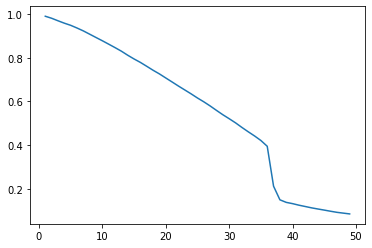

In [16]:
t=range(1,50)
y=kmf.predict(t)
plt.plot(t,y)

In [5]:
df['weight']=df['grade'].map(grade_weight_dict)
grade_weight_array=df['weight'].values
index = df.index
grade_weight_frame = pd.DataFrame(grade_weight_array, index=index)

In [ ]:
# Dropping features not needed for modeling

In [ ]:
drop_list=['sub_grade','issue_d','zip_code','RANDOM','id','weight']
df.drop(drop_list,axis=1,inplace=True)

In [ ]:
x_train=df.drop(['loan_status','return_rate'],axis=1)
y_train=df.return_rate

In [ ]:
cat_list=columns_of_type(x_train,'string')
cont_list=columns_of_type(x_train,'number')

In [ ]:
# Label Encode ALL Categoricals

In [ ]:
label_encoded_df=label_encode_column(x_train,cat_list)

In [ ]:
# Standardize ALL Features

In [ ]:
final_train_df=label_encoded_df.apply(lambda x:feature_standardize(x,scaleType='standardize'),axis=0)

In [ ]:
# CUSTOM SCORING FUNCTION: WEIGHTED R2

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics.scorer import make_scorer
def grade_weighted_r2(y_true,y_pred,sample_weight):

    weighted_r2=r2_score(y_true,y_pred,sample_weight=sample_weight.loc[y_true.index.values].values.reshape(-1))
    return weighted_r2    

score_params = {"sample_weight": grade_weight_frame}

grade_weighted_scorer = make_scorer(score_func=grade_weighted_r2,
                                    greater_is_better=True,
                                    needs_proba=False,
                                    needs_threshold=False,
                                    **score_params)

In [ ]:
grid_para_forest = {
    'n_estimators': range(20, 80, 2),
    'max_depth':[2,3],
    'max_features':[1, 2],
    'min_samples_leaf':[1,2],
    'min_samples_split':[2,3]
}

grid_search_forest = GridSearchCV(estimator = RandomForestRegressor(), param_grid = grid_para_forest,
                                  scoring=grade_weighted_scorer,
                                  cv = 5, n_jobs = -1)

In [ ]:
grid_search_forest.fit(final_train_df,y_train)
print('best parameters:', grid_search_forest.best_params_)
print('best score:', grid_search_forest.best_score_)